In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc, 
    precision_recall_curve, 
    average_precision_score
)
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')

In [3]:
try:
    df = pd.read_csv('Fraud.csv')
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'your_dataset.csv' not found.")
    print("Please make sure the dataset file is in the same directory or provide the full path.")
    exit()

Dataset loaded successfully.
Dataset shape: (6362620, 11)


In [4]:
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [20]:
print(df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].describe())
print("\n")

             amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
count  6.362620e+06   6.362620e+06    6.362620e+06    6.362620e+06   
mean   1.798619e+05   8.338831e+05    8.551137e+05    1.100702e+06   
std    6.038582e+05   2.888243e+06    2.924049e+06    3.399180e+06   
min    0.000000e+00   0.000000e+00    0.000000e+00    0.000000e+00   
25%    1.338957e+04   0.000000e+00    0.000000e+00    0.000000e+00   
50%    7.487194e+04   1.420800e+04    0.000000e+00    1.327057e+05   
75%    2.087215e+05   1.073152e+05    1.442584e+05    9.430367e+05   
max    9.244552e+07   5.958504e+07    4.958504e+07    3.560159e+08   

       newbalanceDest  
count    6.362620e+06  
mean     1.224996e+06  
std      3.674129e+06  
min      0.000000e+00  
25%      0.000000e+00  
50%      2.146614e+05  
75%      1.111909e+06  
max      3.561793e+08  




### Probabilistic Analysis of Transaction Types

In [21]:

type_probability = df['type'].value_counts(normalize=True)
print("Overall Probability of Each Transaction Type:")
print(type_probability)

Overall Probability of Each Transaction Type:
type
CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006512
Name: proportion, dtype: float64


### Calculate the CONDITIONAL probability of fraud given the transaction type
###### This is one of the most important pre-modeling insights.

###### P(Fraud | Type) = (Number of fraudulent transactions of a type) / (Total number of transactions of that type)

In [22]:
conditional_fraud_probability = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
print("Conditional Probability of Fraud Given Transaction Type:")
print(conditional_fraud_probability)
print("\n")

Conditional Probability of Fraud Given Transaction Type:
type
TRANSFER    0.007688
CASH_OUT    0.001840
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64




### Distribution Analysis of Transaction Amount

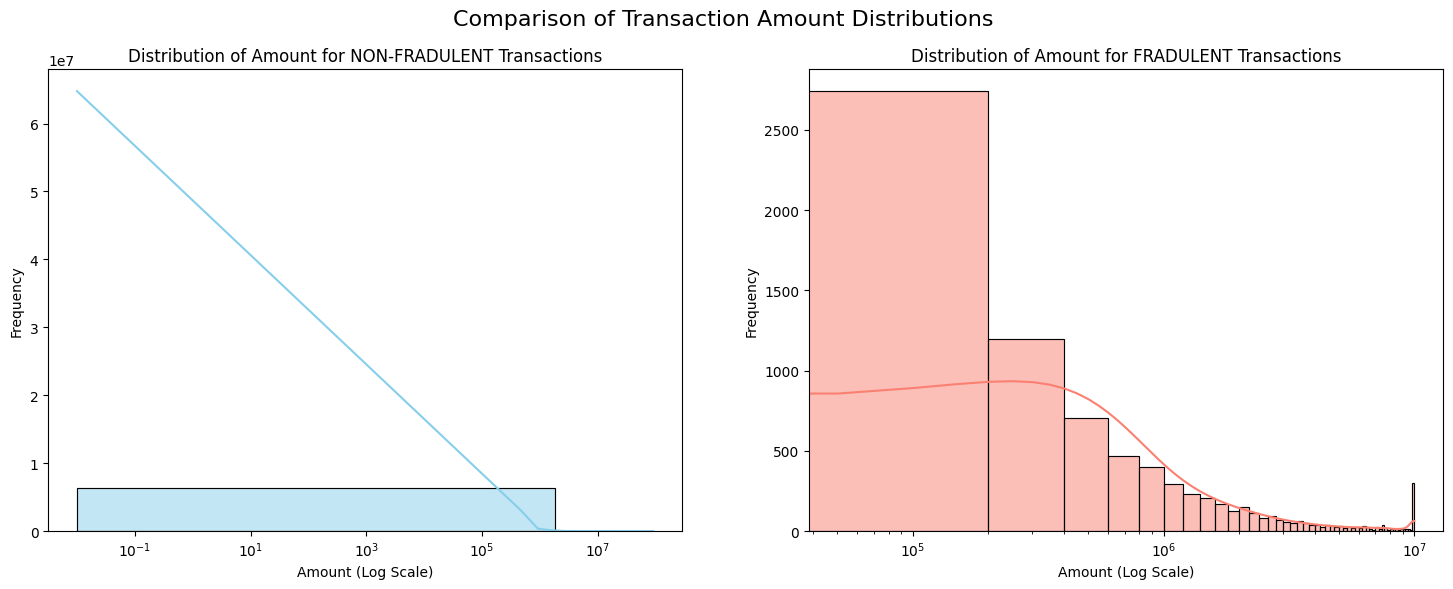

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
# Non-Fraudulent transactions
sns.histplot(df[df['isFraud'] == 0]['amount'], ax=ax[0], bins=50, color='skyblue', kde=True)
ax[0].set_title('Distribution of Amount for NON-FRADULENT Transactions')
ax[0].set_xlabel('Amount (Log Scale)')
ax[0].set_ylabel('Frequency')
ax[0].set_xscale('log') 
# Fraudulent transactions
sns.histplot(df[df['isFraud'] == 1]['amount'], ax=ax[1], bins=50, color='salmon', kde=True)
ax[1].set_title('Distribution of Amount for FRADULENT Transactions')
ax[1].set_xlabel('Amount (Log Scale)')
ax[1].set_ylabel('Frequency')
ax[1].set_xscale('log') 

plt.suptitle('Comparison of Transaction Amount Distributions', fontsize=16)
plt.show()

### Correlation Analysis

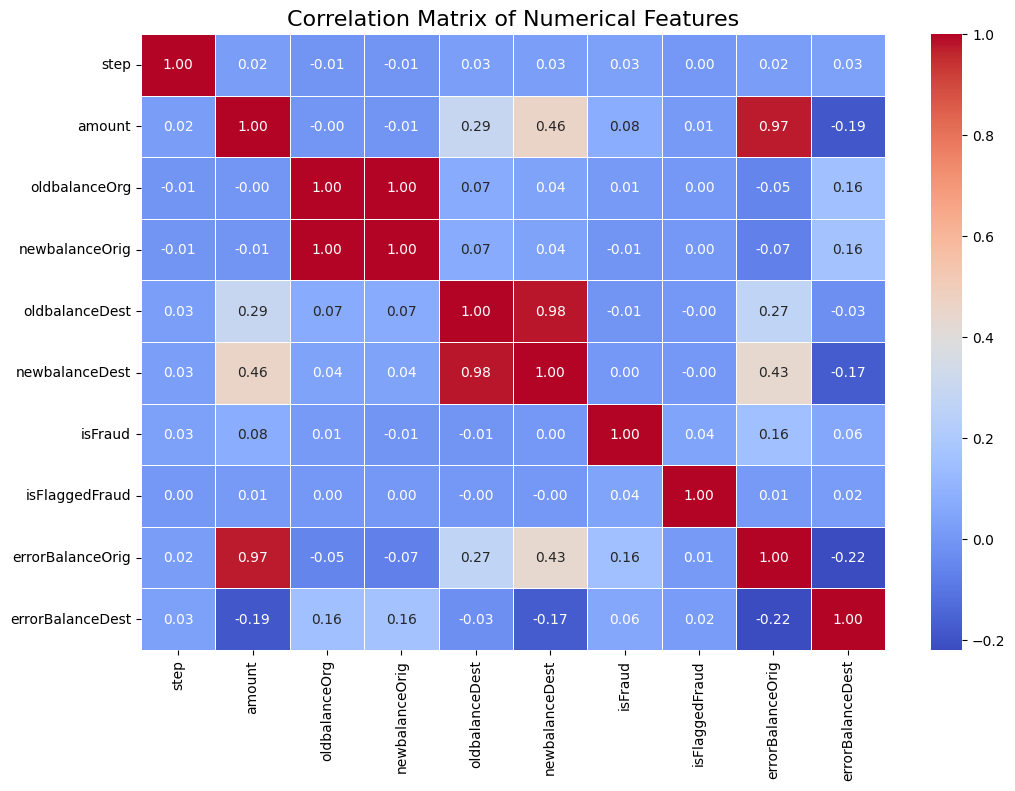

In [ ]:
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=np.number)
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

### Hypothesis Testing

We can use a t-test to determine if the difference in the mean 'amount' between fraudulent and non-fraudulent transactions is statistically significant. Perform an independent two-sample t-test .We use 'equal_var=False' because the variances of the two groups are likely different.Separate the amounts for fraudulent and non-fraudulent transactions

In [ ]:
from scipy import stats

fraud_amounts = df[df['isFraud'] == 1]['amount']
non_fraud_amounts = df[df['isFraud'] == 0]['amount']


t_stat, p_value = stats.ttest_ind(fraud_amounts, non_fraud_amounts, equal_var=False)

print(f"T-test Results for Transaction Amount:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("\nConclusion: The p-value is less than our significance level (0.05).")
    print("We REJECT the null hypothesis. There is a statistically significant difference in the mean transaction amount between fraudulent and non-fraudulent activities.")
else:
    print("\nConclusion: The p-value is greater than our significance level (0.05).")
    print("We FAIL TO REJECT the null hypothesis. There is no statistically significant difference in the mean transaction amount.")

T-test Results for Transaction Amount:
T-statistic: 48.6145
P-value: 0.0

Conclusion: The p-value is less than our significance level (0.05).
We REJECT the null hypothesis. There is a statistically significant difference in the mean transaction amount between fraudulent and non-fraudulent activities.


T-statistic (48.6145): This is a very large number. It indicates that the difference between the average amount of fraudulent transactions and the average amount of non-fraudulent transactions is substantial compared to the variation within each group. A bigger t-statistic suggests a more significant difference.

P-value (0.0): This is the most crucial piece of evidence. A p-value of 0.0 means that the probability of observing such a large difference in the average transaction amounts purely by random chance is practically zero.

The p-value (0.0) is far less than the standard significance level of 0.05, you correctly reject the null hypothesis. 

In [5]:
df['errorBalanceOrig'] = df['oldbalanceOrg'] + df['amount'] - df['newbalanceOrig']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

In [6]:
df_filtered = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()


In [7]:
X = df_filtered.drop(columns=['isFraud', 'step', 'nameOrig', 'nameDest', 'isFlaggedFraud'])
y = df_filtered['isFraud']

In [8]:
print("\n--- One-Hot Encoding 'type' column ---")
X = pd.get_dummies(X, columns=['type'], prefix='type', drop_first=True)
print("Features after One-Hot Encoding:")
print(X.head())


--- One-Hot Encoding 'type' column ---
Features after One-Hot Encoding:
       amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
2      181.00          181.0             0.0             0.0            0.00   
3      181.00          181.0             0.0         21182.0            0.00   
15  229133.94        15325.0             0.0          5083.0        51513.44   
19  215310.30          705.0             0.0         22425.0            0.00   
24  311685.89        10835.0             0.0          6267.0      2719172.89   

    errorBalanceOrig  errorBalanceDest  type_TRANSFER  
2             362.00             181.0           True  
3             362.00           21363.0          False  
15         244458.94          182703.5          False  
19         216015.30          237735.3           True  
24         322520.89        -2401220.0           True  


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [10]:
print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 1939286
Testing set size: 831123


In [ ]:
if y_train.value_counts()[1] > 0:
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
else:
    scale_pos_weight = 1 # Default if no fraud cases in training set..

print(f"\nCalculated 'scale_pos_weight' for handling class imbalance: {scale_pos_weight:.2f}")



Calculated 'scale_pos_weight' for handling class imbalance: 336.33


In [13]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

xgb_model.fit(X_train, y_train)
print("Model training complete.")

Model training complete.


In [14]:
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

In [16]:
print("\nClassification Report ")
print(classification_report(y_test, y_pred))


Classification Report 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.52      0.98      0.68      2464

    accuracy                           1.00    831123
   macro avg       0.76      0.99      0.84    831123
weighted avg       1.00      1.00      1.00    831123



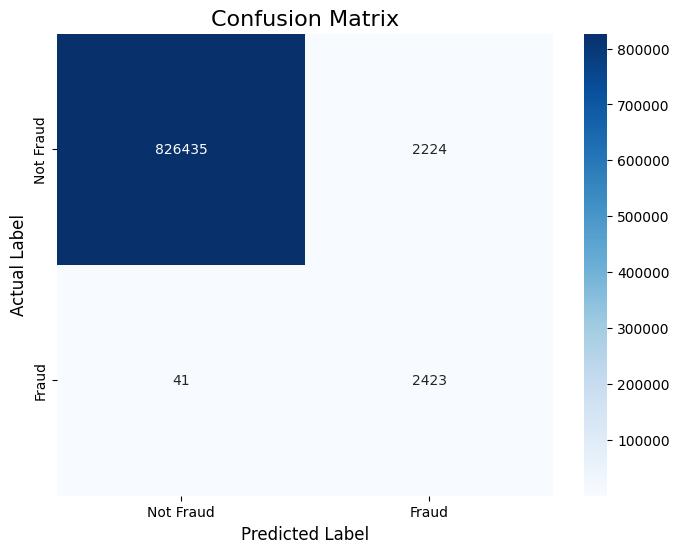

In [19]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)
plt.show()


### Precision-Recall Curve

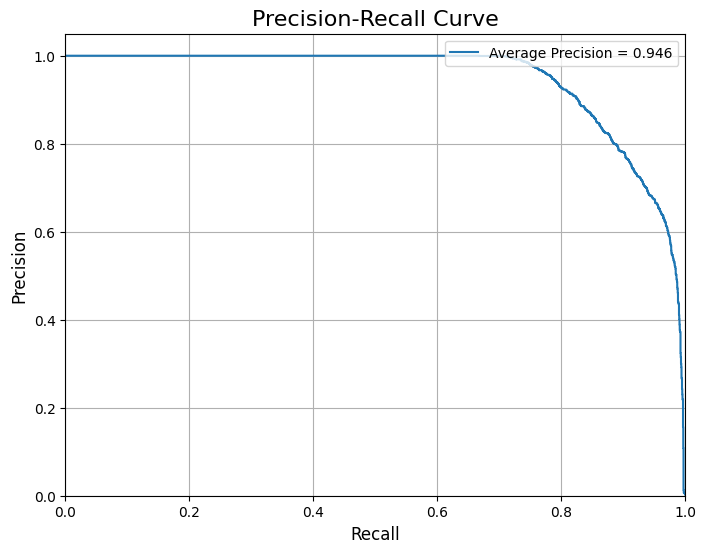

In [33]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', label=f'Average Precision = {avg_precision:.3f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

## Feature Importance

In [34]:
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importances.head(10))


            feature  importance
2    newbalanceOrig    0.355094
1     oldbalanceOrg    0.264556
4    newbalanceDest    0.149151
0            amount    0.088553
7     type_TRANSFER    0.068486
6  errorBalanceDest    0.050808
5  errorBalanceOrig    0.015021
3    oldbalanceDest    0.008332


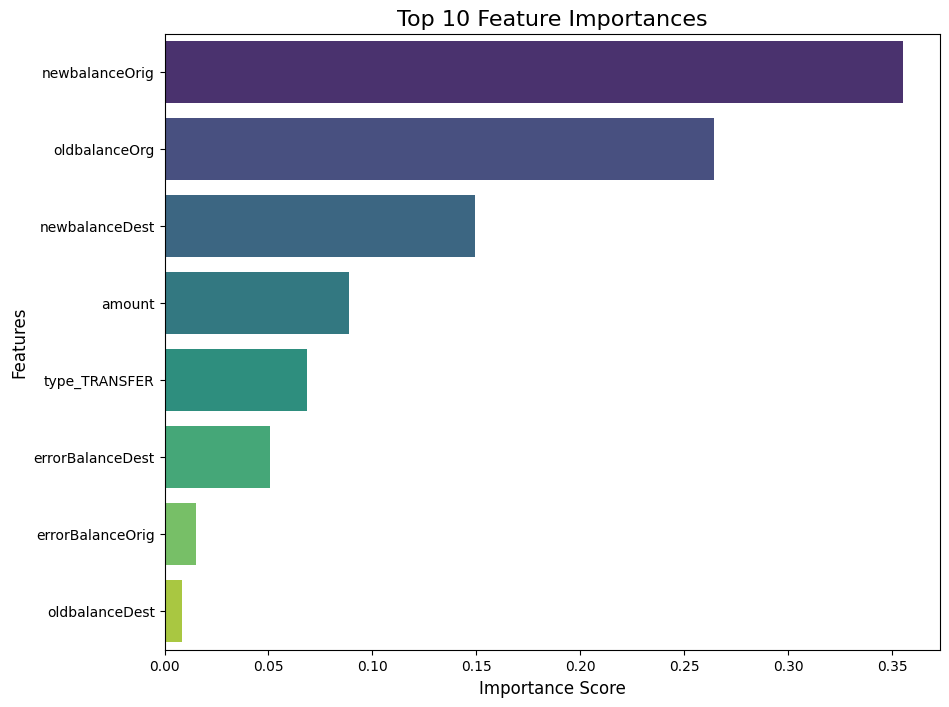

In [35]:
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10), palette='viridis')
plt.title('Top 10 Feature Importances', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()
